# Fake News Detection



In an era of rapid digital information spread distinguishing real from fake news is challenging. The Fake News Detection Dataset helps researchers and data scientists train models for accurate fake news detection.

# SetUp

In [30]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import pickle

In [31]:
# Set seed for reproducibility
SEED = 42

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Explore the Data



## Upzip data

In [32]:
DATA_PATH = "fake_and_real_news.zip"
EXPORT_PATH = 'fake_and_real_news'

# Check if the file exists
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"File not found: {DATA_PATH}. Please download the data and place it in the current working directory.")

with zipfile.ZipFile(DATA_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXPORT_PATH) # Extract to the current working directory

## Load Data

```
fake_and_real_news/
...Fake/
......news_article_1.txt
......news_article_2.txt
...Real/
......news_article_1.txt
......news_article_2.txt
```



In [33]:
# First split: Train (70%) and Temp (30% for val & test)
train_ds = tf.keras.utils.text_dataset_from_directory(
    EXPORT_PATH,
    labels='inferred',
    label_mode='int',
    batch_size=None,
    shuffle=True,
    seed=SEED,
    validation_split=0.3,
    subset='training'
)

raw_val_test_ds = tf.keras.utils.text_dataset_from_directory(
    EXPORT_PATH,
    labels='inferred',
    label_mode='int',
    batch_size=None,
    shuffle=True,
    seed=SEED,
    validation_split=0.3,
    subset='validation'
)

# Second split: Val (20%) and Test (10%)
val_size = int(0.67 * len(raw_val_test_ds))  # 67% of 30% = 20%
test_size = len(raw_val_test_ds) - val_size  # Remaining 10%

val_ds = raw_val_test_ds.take(val_size)
test_ds = raw_val_test_ds.skip(val_size)

# Print dataset sizes
print('\n')
print(f"Train size: {len(train_ds)}")
print(f"Validation size: {len(val_ds)}")
print(f"Test size: {len(test_ds)}")


Found 9900 files belonging to 2 classes.
Using 6930 files for training.
Found 9900 files belonging to 2 classes.
Using 2970 files for validation.


Train size: 6930
Validation size: 1989
Test size: 981


## Check the Data

In [34]:
# for text_batch, label_batch in train_ds.take(5):
#   print("Article", text_batch.numpy())
#   print("Label", label_batch.numpy())

In [35]:
# for index,val in enumerate(train_ds.class_names):
#   print(f"Label {index} corresponds to {val}")


## Collect Key Metrics

In [36]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def plot_class_distribution(labels):
    """Plots the class distribution.

    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    """
    num_classes = len(list(set(train_label.tolist())))
    count_map = Counter(labels)
    counts = [count_map[i] for i in range(num_classes)]
    idx = np.arange(num_classes)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(idx, idx)
    plt.show()

def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.

    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names_out())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()


def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

In [37]:
# Number of samples: Total number of examples you have in the data.
print(len(train_ds))

6930


In [38]:
# Number of classes: Total number of topics or categories in the data.
print(len(train_ds.class_names))

2


In [39]:
# Iterate through the dataset and convert to NumPy arrays
def convert_dataset_to_numpy(dataset):
    texts = []
    labels = []
    for text, label in dataset:
        texts.append(text.numpy().decode('utf-8'))
        labels.append(label.numpy())
    return np.array(texts), np.array(labels)

In [40]:
train_text, train_label = convert_dataset_to_numpy(train_ds)
val_text, val_label = convert_dataset_to_numpy(val_ds)
test_text, test_label = convert_dataset_to_numpy(test_ds)

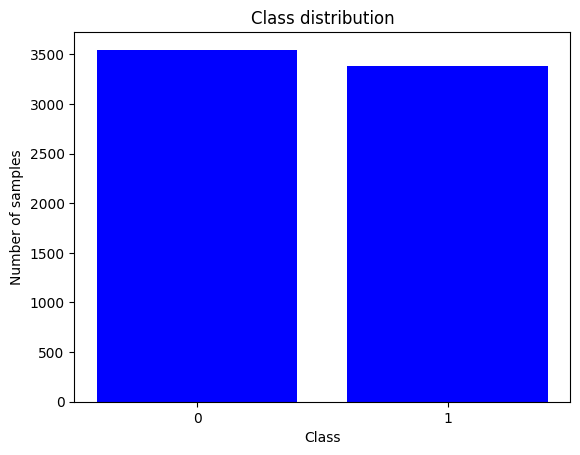

In [41]:
# Number of samples per class: Number of samples per class (topic/category).
plot_class_distribution(train_label)

In [42]:
# Number of words per sample: Median number of words in one sample.
print(get_num_words_per_sample(train_text))

405.0


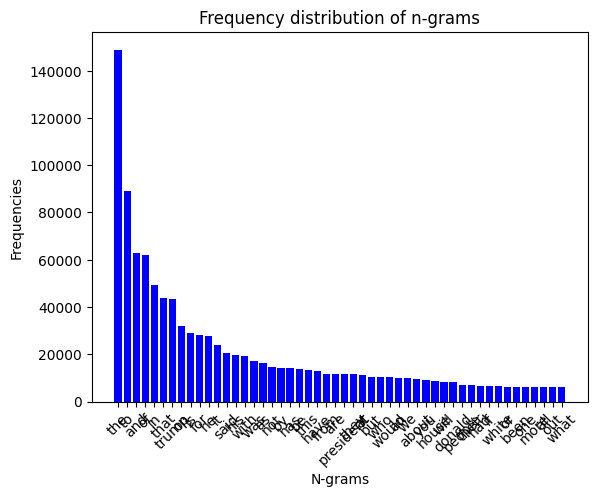

In [43]:
# Frequency distribution of words: Distribution showing the frequency (number of occurrences) of each word in the dataset.
plot_frequency_distribution_of_ngrams(train_text)

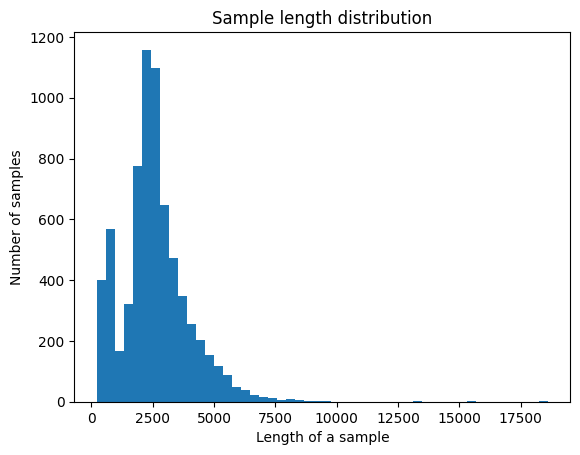

In [44]:
# Distribution of sample length: Distribution showing the number of words per sample in the dataset.
plot_sample_length_distribution(train_text)

# Choose a Model

In [45]:
# Calculate the number of samples/number of words per sample ratio.
number_of_samples = len(train_text)
number_of_words_per_sample = get_num_words_per_sample(train_text)
ratio = number_of_samples / number_of_words_per_sample
print(int(ratio))

17


# Data Preprocessing

1. tokenization
2. vectorization
3. feature selection

In [46]:
def ngram_vectorize(train_texts, train_labels, val_texts, test_texts, top_k=5000):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)
    x_test = vectorizer.transform(test_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(top_k, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    x_test = selector.transform(x_test).astype('float32')

    return x_train, x_val,x_test, vectorizer, selector

In [47]:
x_train, x_val, x_test, vectorizer, selector = ngram_vectorize(train_text, train_label, val_text, test_text)

# Build Model

In [48]:
# Build MLP model
def build_mlp(input_shape):
    model = Sequential([
        Dropout(0.2, input_shape=input_shape),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [49]:
model = build_mlp(x_train.shape[1:])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/regularization/dropout.py:42: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Train Model

In [50]:
# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train model
history = model.fit(x_train, train_label, epochs=100, batch_size=32,
                     validation_data=(x_val, val_label), callbacks=[early_stop], verbose=2)


Epoch 1/100
217/217 - 4s - 18ms/step - accuracy: 0.9560 - loss: 0.2649 - val_accuracy: 0.9884 - val_loss: 0.0743
Epoch 2/100
217/217 - 2s - 11ms/step - accuracy: 0.9913 - loss: 0.0494 - val_accuracy: 0.9930 - val_loss: 0.0334
Epoch 3/100
217/217 - 2s - 9ms/step - accuracy: 0.9960 - loss: 0.0239 - val_accuracy: 0.9940 - val_loss: 0.0209
Epoch 4/100
217/217 - 2s - 9ms/step - accuracy: 0.9986 - loss: 0.0146 - val_accuracy: 0.9960 - val_loss: 0.0145
Epoch 5/100
217/217 - 3s - 12ms/step - accuracy: 0.9994 - loss: 0.0094 - val_accuracy: 0.9970 - val_loss: 0.0109
Epoch 6/100
217/217 - 4s - 21ms/step - accuracy: 0.9999 - loss: 0.0060 - val_accuracy: 0.9975 - val_loss: 0.0086
Epoch 7/100
217/217 - 2s - 11ms/step - accuracy: 0.9999 - loss: 0.0046 - val_accuracy: 0.9980 - val_loss: 0.0073
Epoch 8/100
217/217 - 2s - 9ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9980 - val_loss: 0.0063
Epoch 9/100
217/217 - 3s - 14ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9990 - val

# Evaluate the model

In [51]:
loss, accuracy = model.evaluate(x_test, np.array(test_label), verbose=2)


print("Loss: ", loss)
print("Accuracy: ", accuracy)

31/31 - 0s - 6ms/step - accuracy: 1.0000 - loss: 0.0028
Loss:  0.0027931109070777893
Accuracy:  1.0


In [52]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

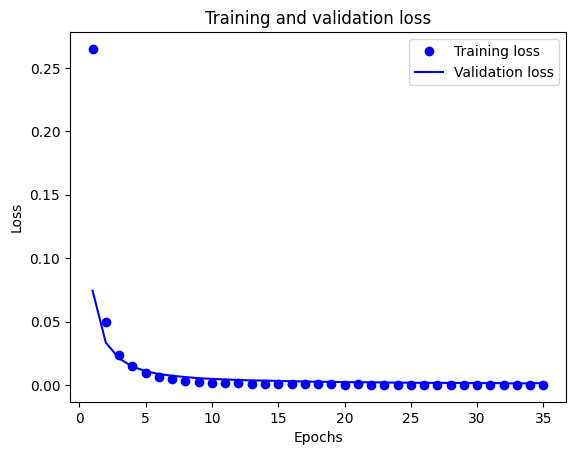

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

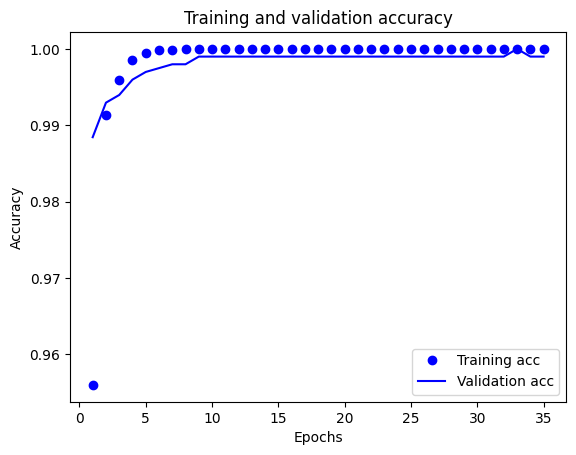

In [54]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Save Model

In [55]:
# Save model and components
model.save('Fake_News_Detector_model.h5')
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
with open("selector.pkl", "wb") as f:
    pickle.dump(selector, f)

In [56]:
def predict_fake_news(text):
    with open("vectorizer.pkl", "rb") as f:
        loaded_vectorizer = pickle.load(f)
    with open("selector.pkl", "rb") as f:
        loaded_selector = pickle.load(f)
    model = tf.keras.models.load_model("Fake_News_Detector_model.h5")

    x_input = loaded_vectorizer.transform([text])
    x_input = loaded_selector.transform(x_input).astype("float32")
    x_input = x_input.toarray()

    pred = model.predict(x_input)[0][0]
    label = "Real News" if pred >= 0.5 else "Fake News"
    confidence = pred if pred >= 0.5 else 1 - pred
    print(f"\nPrediction: {label} (Confidence: {confidence:.2f})")

user_article = input("\nEnter a news article to classify:\n")
predict_fake_news(user_article)



Enter a news article to classify:
At least six people die in what Kyiv claims is largest drone attack since Moscow launched full-scale invasion in February 2022


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

Prediction: Fake News (Confidence: 0.59)
